In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def minmax(df):
    df = df - df.min()
    return df / df.max()

def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


## arrange data
#female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
#female_df = female_df[keep_syllables]

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


#female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v01.parquet').astype(float)
#female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [6]:
f_df.groupby(level='age').size()

age
4.0      16
8.0      16
12.0     16
20.0     16
24.0     16
28.0     15
32.0     16
36.0     16
40.0     16
44.0     16
48.0     16
52.0     15
56.0     16
60.0     16
64.0     16
68.0     16
72.0     16
78.0     16
80.0     15
84.0     16
90.0     11
92.0     11
94.0     15
98.0      8
105.0    12
dtype: int64

In [7]:
#average and normalize female
f_data=f_df.copy()
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

In [8]:
# look at syllable usage diff male and females according to actual age
df = f_data

In [9]:
# upload syllable classes
syllable_classes = pd.read_csv('./v11_syllable_labels_v2.csv')
id_map = syllable_classes.set_index('Original ID')['Class']
class_sort = [id_map[k] for k in df.columns]

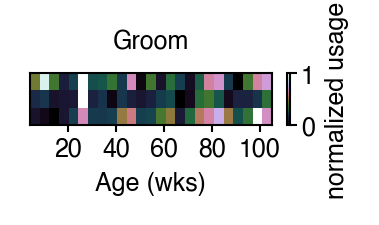

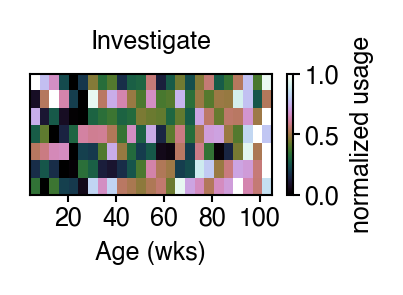

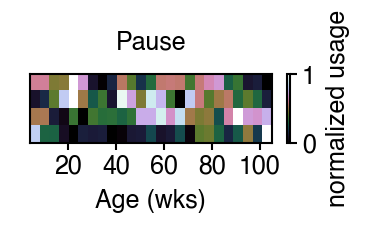

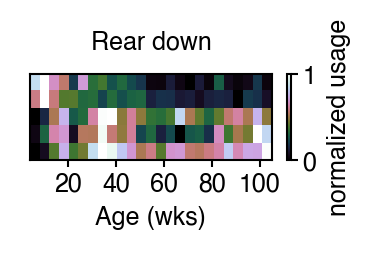

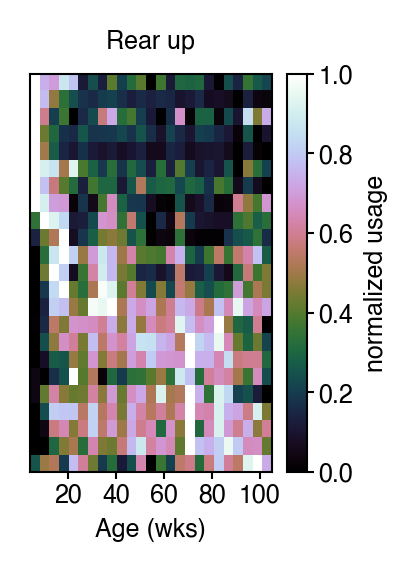

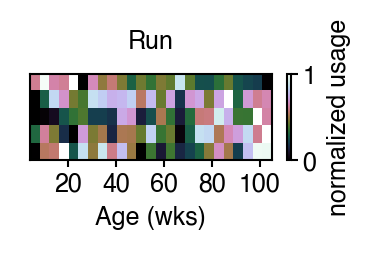

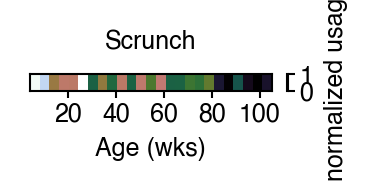

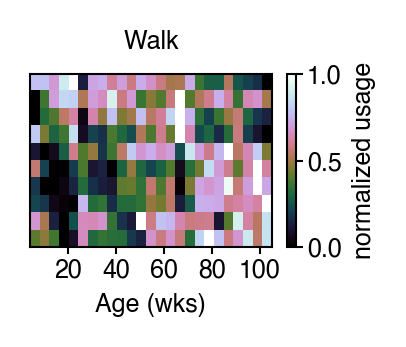

In [10]:
class_avgs = {}
class_norm_avgs = {}
for _class, _df in df.T.groupby(class_sort):
    avgs = _df.T.groupby('age').mean()
    class_avgs[_class] = avgs.mean(1)

    norm_avgs = minmax(avgs)
    #norm_avgs = avgs

    peaks = (
        norm_avgs.rolling(7, min_periods=1, center=True, win_type="exponential")
        .mean(tau=3)
        .idxmax()
    )
    peaks = peaks.sort_values()
    class_norm_avgs[_class] = norm_avgs.mean(1)

    ages = avgs.index

    fig = figure(1.3, 0.075 * avgs.shape[1])
    plt.imshow(norm_avgs[peaks.index].T, cmap='cubehelix', extent=(ages[0], ages[-1], avgs.shape[1], 0), aspect='auto',
              vmax=1,
              )
    plt.title(_class)
    plt.colorbar(label="normalized usage")
    plt.yticks([])
    plt.xticks([20,40,60,80,100])
    plt.xlabel("Age (wks)")
    #sns.despine()
    c = PlotConfig()
    fig.savefig(c.dana_save_path / "fig3"/ f'female_class-{_class}.pdf')


In [11]:
class_df = pd.DataFrame(class_norm_avgs)
peaks = (
    class_df.rolling(7, min_periods=1, center=True, win_type="exponential")
    .mean(tau=3)
    .idxmax()
)
peaks = peaks.sort_values()

In [12]:
col_order = ['Pause', 'Scrunch', 'Groom', 'Rear down','Rear up','Run','Investigate','Walk']
class_df_new = class_df.reindex(columns=col_order)

<Axes: xlabel='age'>

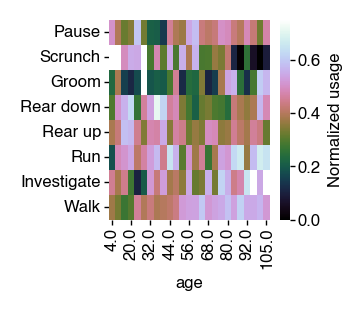

In [13]:
format_plots()
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.heatmap(class_df_new.T, cmap='cubehelix', vmax=0.75, cbar_kws=dict(label='Normalized usage'))
#plt.xticks(ticks=[20, 40, 60, 80, 100])

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_clusters_avg.pdf')